# MODELO 5 - CGAN para generar una imagen del CIFAR-100 a pedido del usuario

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


- Importo las librerias neceasarias

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar100
from keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Embedding, Concatenate
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [2]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

0


- Cargo el dataset

In [3]:
tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

img_size = X_train.shape[1] # tamaño de las imagenes (cuadradas)

X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5 # los valores se escalan para estar en el rango [-1, 1]

print(img_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

32
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


- Ploteo de un número random del dataset junto con su etiqueta

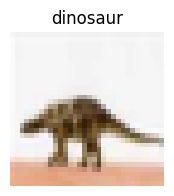

In [4]:
plt.figure(figsize=(2,2))
idx = np.random.randint(0,len(X_train))
img = image.array_to_img(X_train[idx], scale=True)
plt.imshow(img)
plt.axis('off')
plt.title(tags[y_train[idx][0]])
plt.show()

# Construcción del generador

In [ ]:
def build_generator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label) # Capa de embedding para las etiquetas
    img_size_in = img_size // 4
    n_nodes = img_size_in * img_size_in
    li = Dense(n_nodes, name='Label_Dense')(li) # Capa densa para las etiquetas
    li = Reshape((img_size_in, img_size_in, 1), name='Label_Reshape')(li) # Cambio la forma de la capa

    in_lat = Input(shape=(noise_dim,), name='Latent_Input') # Capa de entrada de ruido
    n_nodes = 1024 * img_size_in * img_size_in
    gen = Dense(n_nodes, name='Generator_Dense')(in_lat) # Capa densa para el ruido
    gen = Reshape((img_size_in, img_size_in, 1024), name='Generator_Reshape')(gen) # Cambio la forma de la capa
    #---------------------------------------------------------------------------------#
    merge = Concatenate(name='Concatenate')([gen, li]) # Concateno las capas
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(1024, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_1')(merge)  # 16x16x1024
    gen = BatchNormalization(name='Generator_BatchNormalization_1')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_1')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', name='Conv2DTranspose_2')(gen)  # 32x32x512
    gen = BatchNormalization(name='Generator_BatchNormalization_2')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_2')(gen)
    #---------------------------------------------------------------------------------#
    gen = Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', name='Conv2DTranspose_3')(gen)  # 32x32x256
    gen = BatchNormalization(name='Generator_BatchNormalization_3')(gen)
    gen = LeakyReLU(alpha=0.2, name='Generator_LeakyReLU_3')(gen)
    #---------------------------------------------------------------------------------#
    out_layer = Conv2DTranspose(3, (5, 5), strides=(1,1), activation='tanh', padding='same', name='Output_Conv2DTranspose_4')(gen)  # 32x32x3
    #---------------------------------------------------------------------------------#

    generator = Model([in_lat, in_label], out_layer, name='Generator')
    plot_model(generator, to_file='/content/drive/MyDrive/Lembo/generator_structure_m5_cifar100.png', show_shapes=True, show_layer_names=True)

    return generator

# Construcción del discriminador

In [ ]:
def build_discriminator(n_class, noise_dim, img_size):

    in_label = Input(shape=(1,), name='Label_Input')
    li = Embedding(n_class, 50, name='Embedding')(in_label)
    n_nodes = img_size * img_size
    li = Dense(n_nodes, name='Label_Dense')(li)
    li = Reshape((img_size, img_size, 1), name='Label_Reshape')(li)

    in_image = Input(shape=(img_size, img_size, 3), name='Image_Input')
    #in_image = Dropout(0.75, name='Dropout')(in_image)
    merge = Concatenate(name='Concatenate')([in_image, li])
    #---------------------------------------------------------------------------------#
    fe = Conv2D(32, (5, 5), strides=(2, 2), padding='same', name='Conv2D_1')(merge) # 16x16x32
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_1')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(64, (5, 5), strides=(2, 2), padding='same', name='Conv2D_2')(fe) # 8x8x64
    fe = BatchNormalization(name='Generator_BatchNormalization_1')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_2')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2D_3')(fe) # 4x4x128
    fe = BatchNormalization(name='Generator_BatchNormalization_2')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_3')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(256, (5, 5), strides=(2, 2), padding='same', name='Conv2D_4')(fe) # 4x4x128
    fe = BatchNormalization(name='Generator_BatchNormalization_4')(fe)
    fe = LeakyReLU(alpha=0.2, name='LeakyReLU_4')(fe)
    #---------------------------------------------------------------------------------#
    fe = Conv2D(512, (5, 5), strides=(2, 2), padding='same', name='Conv2D_5')(fe) # 2x2x256
    #---------------------------------------------------------------------------------#
    fe = Flatten(name='Flatten')(fe)
    fe = Dropout(0.4, name='Dropout')(fe)
    out_layer = Dense(1, activation='sigmoid', name='Output_Dense')(fe)
    #---------------------------------------------------------------------------------#

    discriminator = Model([in_image, in_label], out_layer, name='Discriminator')
    plot_model(discriminator, to_file='/content/drive/MyDrive/Lembo/discriminator_structure_m5_cifar100.png', show_shapes=True, show_layer_names=True)

    return discriminator

# Función para visualizar el entrenamiento del generador

In [ ]:
def show_samples(num_samples, noise_dim, g_model, epoch):

  fig, axes = plt.subplots(10, num_samples, figsize=(10,20))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=None)

  for l in np.arange(10):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l,j].imshow(img)
      axes[l,j].yaxis.set_ticks([])
      axes[l,j].xaxis.set_ticks([])

      if j ==0:
        axes[l,j].set_ylabel(tags[l])

  os.makedirs("/content/drive/MyDrive/Lembo/evolution_m5_cifar100", exist_ok=True)
  plt.savefig(f"/content/drive/MyDrive/Lembo/evolution_m5_cifar100/images_epoch={epoch}.png", bbox_inches='tight')
  plt.close(fig)

# Definición de las funciones de pérdida (loss)

In [ ]:
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real), real) # Calculo la loss para las imagenes reales
    fake_loss = bce_loss(tf.zeros_like(fake), fake) # Calculo la loss para las imagenes falsas
    total_loss = real_loss + fake_loss
    return total_loss

# Generator Loss
def generator_loss(preds):
    return bce_loss(tf.ones_like(preds), preds) # Calculo la loss para el generador

# Definición de las métricas para evaluar el modelo

In [ ]:
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, f1, accuracy

# Entrenamiento de la CGAN

- Parámetros de entrenamiento

In [ ]:
epoch_count = 50 # Cantidad de epocas
batch_size = 16 #tamaño del batch hay 60000/16 = 3750 batches
noise_dim = 100 # Dimension del ruido
lr = 0.0002 # Learning rate
n_class = len(tags)  # numero de clases

- Construyo el generador

In [ ]:
g_optimizer = RMSprop(learning_rate=lr)
g_model = build_generator(noise_dim=noise_dim, n_class=n_class, img_size=img_size) # Construyo el generador
g_model.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Latent_Input (InputLayer)   [(None, 100)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                5000      ['Label_Input[0][0]']         
                                                                                                  
 Generator_Dense (Dense)     (None, 65536)                6619136   ['Latent_Input[0][0]']        
                                                                                          

- Construyo el discriminador

In [ ]:
d_optimizer = RMSprop(learning_rate=lr)
d_model = build_discriminator(n_class=n_class, noise_dim=noise_dim, img_size=img_size) # Construyo el discriminador
d_model.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Label_Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 1, 50)                5000      ['Label_Input[0][0]']         
                                                                                                  
 Label_Dense (Dense)         (None, 1, 1024)              52224     ['Embedding[0][0]']           
                                                                                                  
 Image_Input (InputLayer)    [(None, 32, 32, 3)]          0         []                            
                                                                                      

- Paso de entrenamiento por batches para el conjunto de entrenamiento (se actualizan los pesos)

In [ ]:
@tf.function # Compiles the train_step function into a callable TensorFlow graph
def train_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = g_model([noise, real_labels], training = True) #  Genero imagenes falsas
            pred_real = d_model([real_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes reales
            pred_fake = d_model([generated_images, real_labels], training = True) # Obtengo las predicciones del discriminador para las imagenes falsas

            g_loss = generator_loss(pred_fake) # Calculo la loss del generador
            d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador

        grads_g = gen_tape.gradient(g_loss, g_model.trainable_variables) # Calculo los gradientes
        grads_d = disc_tape.gradient(d_loss, d_model.trainable_variables) # Calculo los gradientes

        g_optimizer.apply_gradients(zip(grads_g, g_model.trainable_variables)) # Aplico los gradientes al optimizador del generador
        d_optimizer.apply_gradients(zip(grads_d, d_model.trainable_variables)) # Aplico los gradientes al optimizador del discriminador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

- Paso de entrenamiento por batches para el conjunto de entrenamiento (no se actualizan los pesos)

In [ ]:
@tf.function # Compiles the test_step function into a callable TensorFlow graph
def test_step(image_batch, batch_size, noise_dim):
    with tf.device('/device:GPU:0'):

        real_images, real_labels = image_batch
        noise = tf.random.normal(shape=(batch_size, noise_dim)) # Genero ruido aleatorio
        generated_images = g_model([noise, real_labels]) #  Genero imagenes falsas

        pred_fake = d_model([generated_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes falsas
        pred_real = d_model([real_images, real_labels]) # Obtengo las predicciones del discriminador para las imagenes reales

        d_loss = discriminator_loss(pred_real, pred_fake) # Calculo la loss del discriminador
        g_loss = generator_loss(pred_fake) # Calculo la loss del generador

        all_real_labels = [] # Guardo las etiquetas reales
        all_pred_labels = []  # Guardo las etiquetas predichas

        for i in range(batch_size):
            all_real_labels.append(1)  # Etiqueta real para imágenes reales
            all_pred_labels.append(pred_real[i])  # Etiqueta predicha para imágenes reales
        for i in range(batch_size):
            all_real_labels.append(0)  # Etiqueta real para imágenes falsas
            all_pred_labels.append(pred_fake[i])  # Etiqueta predicha para imágenes falsas

    return d_loss, g_loss, all_real_labels, all_pred_labels

In [ ]:
def train(train_dataset, test_dataset, epoch_count, batch_size):

    num_train_batches = len(train_dataset)
    num_test_batches = len(test_dataset)

    d_loss_list_epoch_train = np.zeros(epoch_count)
    g_loss_list_epoch_train = np.zeros(epoch_count)
    d_loss_list_epoch_test = np.zeros(epoch_count)
    g_loss_list_epoch_test = np.zeros(epoch_count)
    precision_list_epoch_train = np.zeros(epoch_count)
    recall_list_epoch_train = np.zeros(epoch_count)
    f1_list_epoch_train = np.zeros(epoch_count)
    accuracy_list_epoch_train = np.zeros(epoch_count)
    precision_list_epoch_test = np.zeros(epoch_count)
    recall_list_epoch_test = np.zeros(epoch_count)
    f1_list_epoch_test = np.zeros(epoch_count)
    accuracy_list_epoch_test = np.zeros(epoch_count)
    d_loss_list_itern_train = np.zeros(epoch_count *num_train_batches)
    g_loss_list_itern_train = np.zeros(epoch_count * num_train_batches)
    d_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)
    g_loss_list_itern_test = np.zeros(epoch_count * num_test_batches)

    itern_train_counter = 0
    itern_test_counter = 0

    for epoch in range(epoch_count):
        print('Epoch: ', epoch+1)

        d_loss_list_batch_train_aux = np.zeros(num_train_batches)
        g_loss_list_batch_train_aux = np.zeros(num_train_batches)
        d_loss_list_batch_test_aux = np.zeros(num_test_batches)
        g_loss_list_batch_test_aux = np.zeros(num_test_batches)
        precision_list_batch_train = np.zeros(num_train_batches)
        recall_list_batch_train = np.zeros(num_train_batches)
        f1_list_batch_train = np.zeros(num_train_batches)
        accuracy_list_batch_train = np.zeros(num_train_batches)
        precision_list_batch_test = np.zeros(num_test_batches)
        recall_list_batch_test = np.zeros(num_test_batches)
        f1_list_batch_test = np.zeros(num_test_batches)
        accuracy_list_batch_test = np.zeros(num_test_batches)

        start = time.time()

        itern = 0
        for image_batch in tqdm(train_dataset, desc=f"Train - batch/batches: "): # Itero sobre todos los batches para el conjunto de entrenamiento

            d_loss_train, g_loss_train, all_real_labels_train, all_pred_labels_train = train_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_train_aux[itern] = d_loss_train
            g_loss_list_batch_train_aux[itern] = g_loss_train
            d_loss_list_itern_train[itern_train_counter] = d_loss_train
            g_loss_list_itern_train[itern_train_counter] = g_loss_train
            itern_train_counter += 1

            all_real_labels_train = np.array(all_real_labels_train)
            all_pred_labels_train = np.array(all_pred_labels_train)
            all_pred_labels_train = np.array([i[0] for i in all_pred_labels_train]).reshape((-1,)) # Reshapeo para que all_pred_labels_train (tiene la dimensión de la salida del discriminador) tenga la misma forma que all_real_labels_train

            precision_train, recall_train, f1_train, accuracy_train = calculate_metrics(np.round(all_real_labels_train), np.round(all_pred_labels_train))
            precision_list_batch_train[itern] = precision_train
            recall_list_batch_train[itern] = recall_train
            f1_list_batch_train[itern] = f1_train
            accuracy_list_batch_train[itern] = accuracy_train
            itern=itern+1

        itern = 0
        for image_batch in tqdm(test_dataset, desc=f"Test - batch/batches: "): # Itero sobre todos los batches para el conjunto de testeo

            d_loss_test, g_loss_test, all_real_labels_test, all_pred_labels_test = test_step(image_batch, batch_size, noise_dim) # Entreno el modelo

            d_loss_list_batch_test_aux[itern] = d_loss_test
            g_loss_list_batch_test_aux[itern] = g_loss_test
            d_loss_list_itern_test[itern_test_counter] = d_loss_test
            g_loss_list_itern_test[itern_test_counter] = g_loss_test
            itern_test_counter += 1

            all_real_labels_test = np.array(all_real_labels_test)
            all_pred_labels_test = np.array(all_pred_labels_test)
            all_pred_labels_test = np.array([i[0] for i in all_pred_labels_test]).reshape((-1,))

            precision_test, recall_test, f1_test, accuracy_test = calculate_metrics(np.round(all_real_labels_test), np.round(all_pred_labels_test))
            precision_list_batch_test[itern] = precision_test
            recall_list_batch_test[itern] = recall_test
            f1_list_batch_test[itern] = f1_test
            accuracy_list_batch_test[itern] = accuracy_test

            itern=itern+1

        d_loss_list_epoch_train[epoch] = np.mean(d_loss_list_batch_train_aux)
        g_loss_list_epoch_train[epoch] = np.mean(g_loss_list_batch_train_aux)
        d_loss_list_epoch_test[epoch] = np.mean(d_loss_list_batch_test_aux)
        g_loss_list_epoch_test[epoch] = np.mean(g_loss_list_batch_test_aux)
        precision_list_epoch_train[epoch] = np.mean(precision_list_batch_train)
        recall_list_epoch_train[epoch] = np.mean(recall_list_batch_train)
        f1_list_epoch_train[epoch] = np.mean(f1_list_batch_train)
        accuracy_list_epoch_train[epoch] = np.mean(accuracy_list_batch_train)
        precision_list_epoch_test[epoch] = np.mean(precision_list_batch_test)
        recall_list_epoch_test[epoch] = np.mean(recall_list_batch_test)
        f1_list_epoch_test[epoch] = np.mean(f1_list_batch_test)
        accuracy_list_epoch_test[epoch] = np.mean(accuracy_list_batch_test)

        print (f'Train - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_train_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_train_aux)}')
        print (f'Test - Época: {epoch+1} -- Generator Loss: {np.mean(g_loss_list_batch_test_aux)}, Discriminator Loss: {np.mean(d_loss_list_batch_test_aux)}\n')
        print (f'Tomó {time.time()-start} segundos. \n\n')

        if epoch % 5 == 0:
            show_samples(4, noise_dim, g_model, epoch)

    return d_loss_list_itern_train, g_loss_list_itern_train, d_loss_list_itern_test, g_loss_list_itern_test, d_loss_list_epoch_train, g_loss_list_epoch_train, d_loss_list_epoch_test, g_loss_list_epoch_test, precision_list_epoch_train, recall_list_epoch_train, f1_list_epoch_train, accuracy_list_epoch_train, precision_list_epoch_test, recall_list_epoch_test, f1_list_epoch_test, accuracy_list_epoch_test

- Entrenamiento del modelo

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) # Se crea un dataset con los datos de entrenamiento
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) # Se crea un dataset con los datos de test
test_dataset = test_dataset.shuffle(buffer_size=1000).batch(batch_size) # Se mezclan los datos del dataset cada 1000 y se agrupan en batches de a 16

d_loss_itern_train, g_loss_itern_train, d_loss_itern_test, g_loss_itern_test, d_loss_train, g_loss_train, d_loss_test, g_loss_test, precision_train, recall_train, f1_train, accuracy_train, precision_test, recall_test, f1_test, accuracy_test  = train(train_dataset, test_dataset, epoch_count, batch_size)
epochs = np.arange(1, epoch_count+1)

np.savez("/content/drive/MyDrive/Lembo/metricas_m5_cifar100.npz", epochs= epochs, d_loss_itern_train=d_loss_itern_train, g_loss_itern_train=g_loss_itern_train, d_loss_itern_test=d_loss_itern_test, g_loss_itern_test=g_loss_itern_test, d_loss_train=d_loss_train, g_loss_train=g_loss_train, d_loss_test=d_loss_test, g_loss_test=g_loss_test, precision_train=precision_train, recall_train=recall_train, f1_train=f1_train, accuracy_train=accuracy_train, precision_test=precision_test, recall_test=recall_test, f1_test=f1_test, accuracy_test=accuracy_test)
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m5_cifar100.keras")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m5_cifar100.keras")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m5_cifar100.h5")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m5_cifar100.h5")
g_model.save("/content/drive/MyDrive/Lembo/gmodel_m5_cifar100.tf")
d_model.save("/content/drive/MyDrive/Lembo/dmodel_m5_cifar100.tf")

Epoch:  1


Test - batch/batches: 100%|██████████| 625/625 [00:15<00:00, 40.03it/s]


Train - Época: 1 -- Generator Loss: 1.1915262390375136, Discriminator Loss: 1.2603588335180282
Test - Época: 1 -- Generator Loss: 1.2889834646224976, Discriminator Loss: 1.3042453128814697

Tomó 129.4198660850525 segundos. 


1/1 [==============================] - 0s 22ms/step
Epoch:  2


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.60it/s]


Train - Época: 2 -- Generator Loss: 1.733174159705639, Discriminator Loss: 0.9693512105107307
Test - Época: 2 -- Generator Loss: 0.6996185342788697, Discriminator Loss: 1.3108642086029052

Tomó 114.79867267608643 segundos. 


Epoch:  3


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.88it/s]


Train - Época: 3 -- Generator Loss: 1.918133224593997, Discriminator Loss: 0.8906128873085976
Test - Época: 3 -- Generator Loss: 0.6593938054561616, Discriminator Loss: 1.397752010345459

Tomó 113.78554034233093 segundos. 


Epoch:  4


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.14it/s]


Train - Época: 4 -- Generator Loss: 2.046386176354289, Discriminator Loss: 0.856606085293293
Test - Época: 4 -- Generator Loss: 1.1565033987998963, Discriminator Loss: 1.350747285079956

Tomó 114.40280199050903 segundos. 


Epoch:  5


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.92it/s]


Train - Época: 5 -- Generator Loss: 2.1637078527498246, Discriminator Loss: 0.8183524998348951
Test - Época: 5 -- Generator Loss: 0.97181447763443, Discriminator Loss: 1.4363057375907897

Tomó 114.31565284729004 segundos. 


Epoch:  6


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.08it/s]


Train - Época: 6 -- Generator Loss: 2.2852942225933073, Discriminator Loss: 0.7910935496395827
Test - Época: 6 -- Generator Loss: 0.8280327721118927, Discriminator Loss: 1.3283725006103515

Tomó 114.71297645568848 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  7


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.55it/s]


Train - Época: 7 -- Generator Loss: 2.4453237245750428, Discriminator Loss: 0.7532426043719054
Test - Época: 7 -- Generator Loss: 1.1510679438591003, Discriminator Loss: 1.1995023056983947

Tomó 114.34244203567505 segundos. 


Epoch:  8


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.90it/s]


Train - Época: 8 -- Generator Loss: 2.715007587912679, Discriminator Loss: 0.6942623775303364
Test - Época: 8 -- Generator Loss: 0.9168658557891846, Discriminator Loss: 1.2341093455314636

Tomó 114.58008980751038 segundos. 


Epoch:  9


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.90it/s]


Train - Época: 9 -- Generator Loss: 2.8138029284670947, Discriminator Loss: 0.6804292398287356
Test - Época: 9 -- Generator Loss: 1.3015847966194152, Discriminator Loss: 1.3923785720825195

Tomó 113.96448945999146 segundos. 


Epoch:  10


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.63it/s]


Train - Época: 10 -- Generator Loss: 2.8390226943168044, Discriminator Loss: 0.6685058121904731
Test - Época: 10 -- Generator Loss: 0.6650876894950867, Discriminator Loss: 1.4144534896850587

Tomó 114.62975573539734 segundos. 


Epoch:  11


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.63it/s]


Train - Época: 11 -- Generator Loss: 2.897771189322248, Discriminator Loss: 0.6619655359235406
Test - Época: 11 -- Generator Loss: 1.1338205026626587, Discriminator Loss: 1.3709493145942688

Tomó 114.17447066307068 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  12


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.76it/s]


Train - Época: 12 -- Generator Loss: 3.014782369866967, Discriminator Loss: 0.6345485628374666
Test - Época: 12 -- Generator Loss: 1.100313646888733, Discriminator Loss: 1.3506276608467103

Tomó 114.37787795066833 segundos. 


Epoch:  13


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.44it/s]


Train - Época: 13 -- Generator Loss: 2.942829945588112, Discriminator Loss: 0.6459357767079398
Test - Época: 13 -- Generator Loss: 0.8143769368171692, Discriminator Loss: 1.3002716039657594

Tomó 114.54249048233032 segundos. 


Epoch:  14


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.50it/s]


Train - Época: 14 -- Generator Loss: 3.0014331389546394, Discriminator Loss: 0.6346946089593322
Test - Época: 14 -- Generator Loss: 1.1649797786712646, Discriminator Loss: 1.2546834301948548

Tomó 115.24374437332153 segundos. 


Epoch:  15


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.99it/s]


Train - Época: 15 -- Generator Loss: 2.9552184214331207, Discriminator Loss: 0.6308616715789587
Test - Época: 15 -- Generator Loss: 1.4793503895759583, Discriminator Loss: 1.3381999852180482

Tomó 114.58984136581421 segundos. 


Epoch:  16


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.87it/s]


Train - Época: 16 -- Generator Loss: 3.1177320507352055, Discriminator Loss: 0.6126103290810436
Test - Época: 16 -- Generator Loss: 1.344604871559143, Discriminator Loss: 1.3486721544265747

Tomó 114.26144742965698 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  17


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.60it/s]


Train - Época: 17 -- Generator Loss: 3.059068169809878, Discriminator Loss: 0.6186963478134573
Test - Época: 17 -- Generator Loss: 1.1745071786880492, Discriminator Loss: 1.3704639987945557

Tomó 115.41898989677429 segundos. 


Epoch:  18


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.80it/s]


Train - Época: 18 -- Generator Loss: 3.122742283513546, Discriminator Loss: 0.6030809242784232
Test - Época: 18 -- Generator Loss: 1.3009094003677368, Discriminator Loss: 1.3335741094589233

Tomó 114.2215416431427 segundos. 


Epoch:  19


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.30it/s]


Train - Época: 19 -- Generator Loss: 3.122621696039438, Discriminator Loss: 0.6072592611305415
Test - Época: 19 -- Generator Loss: 0.8934670123577118, Discriminator Loss: 1.3959809025764465

Tomó 114.84330153465271 segundos. 


Epoch:  20


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.27it/s]


Train - Época: 20 -- Generator Loss: 3.1069864518773556, Discriminator Loss: 0.6084444808149337
Test - Época: 20 -- Generator Loss: 0.7914446210384369, Discriminator Loss: 1.5036368728637695

Tomó 115.1947762966156 segundos. 


Epoch:  21


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.37it/s]


Train - Época: 21 -- Generator Loss: 3.1131864833419023, Discriminator Loss: 0.6032059503751993
Test - Época: 21 -- Generator Loss: 1.0120892707824707, Discriminator Loss: 1.2738744482040405

Tomó 115.33116507530212 segundos. 


1/1 [==============================] - 0s 22ms/step
Epoch:  22


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.33it/s]


Train - Época: 22 -- Generator Loss: 3.223492561030835, Discriminator Loss: 0.586791738017574
Test - Época: 22 -- Generator Loss: 1.720160245704651, Discriminator Loss: 1.4173227919578553

Tomó 115.25219631195068 segundos. 


Epoch:  23


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.35it/s]


Train - Época: 23 -- Generator Loss: 3.415262790685892, Discriminator Loss: 0.5670534320309386
Test - Época: 23 -- Generator Loss: 1.63272034740448, Discriminator Loss: 1.4214093503952026

Tomó 115.33852410316467 segundos. 


Epoch:  24


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 41.94it/s]


Train - Época: 24 -- Generator Loss: 3.29950003777802, Discriminator Loss: 0.5798307229162007
Test - Época: 24 -- Generator Loss: 0.900891236448288, Discriminator Loss: 1.3471537002563476

Tomó 115.19139266014099 segundos. 


Epoch:  25


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.59it/s]


Train - Época: 25 -- Generator Loss: 3.3519353021544216, Discriminator Loss: 0.5689801707854867
Test - Época: 25 -- Generator Loss: 0.7371052859306335, Discriminator Loss: 1.4080557899475097

Tomó 115.35633373260498 segundos. 


Epoch:  26


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.28it/s]


Train - Época: 26 -- Generator Loss: 3.355955660598278, Discriminator Loss: 0.5656429471188038
Test - Época: 26 -- Generator Loss: 0.7911867949008942, Discriminator Loss: 1.3410960920333863

Tomó 115.52610683441162 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  27


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.40it/s]


Train - Época: 27 -- Generator Loss: 3.3389816326832773, Discriminator Loss: 0.5713212665457279
Test - Época: 27 -- Generator Loss: 0.8104993716239929, Discriminator Loss: 1.3415182927131653

Tomó 115.10970878601074 segundos. 


Epoch:  28


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.47it/s]


Train - Época: 28 -- Generator Loss: 3.39287443764925, Discriminator Loss: 0.5579506076741219
Test - Época: 28 -- Generator Loss: 1.2658255157470704, Discriminator Loss: 1.2702581874847412

Tomó 114.99357795715332 segundos. 


Epoch:  29


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.55it/s]


Train - Época: 29 -- Generator Loss: 3.4342539891661703, Discriminator Loss: 0.5613869850160368
Test - Época: 29 -- Generator Loss: 1.014150825023651, Discriminator Loss: 1.3038662623405457

Tomó 114.31566953659058 segundos. 


Epoch:  30


Test - batch/batches: 100%|██████████| 625/625 [00:15<00:00, 41.29it/s]


Train - Época: 30 -- Generator Loss: 3.43567552372396, Discriminator Loss: 0.5488126658550277
Test - Época: 30 -- Generator Loss: 0.7886239530086517, Discriminator Loss: 1.5094930345535278

Tomó 115.74366426467896 segundos. 


Epoch:  31


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.10it/s]


Train - Época: 31 -- Generator Loss: 3.40001974454768, Discriminator Loss: 0.5560027144611255
Test - Época: 31 -- Generator Loss: 0.8918065876483917, Discriminator Loss: 1.5453323347091674

Tomó 116.12279772758484 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  32


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.27it/s]


Train - Época: 32 -- Generator Loss: 3.4940239416977765, Discriminator Loss: 0.5416620687552169
Test - Época: 32 -- Generator Loss: 1.2284850079536438, Discriminator Loss: 1.2986046675682068

Tomó 115.3201847076416 segundos. 


Epoch:  33


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.14it/s]


Train - Época: 33 -- Generator Loss: 3.4360158758628367, Discriminator Loss: 0.5502739120732993
Test - Época: 33 -- Generator Loss: 1.4057131939888001, Discriminator Loss: 1.3729916370391846

Tomó 115.38362836837769 segundos. 


Epoch:  34


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 41.88it/s]


Train - Época: 34 -- Generator Loss: 3.493933142889142, Discriminator Loss: 0.5387773840125277
Test - Época: 34 -- Generator Loss: 0.8411976213932038, Discriminator Loss: 1.4529675814628602

Tomó 115.82125949859619 segundos. 


Epoch:  35


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.28it/s]


Train - Época: 35 -- Generator Loss: 3.714413983246684, Discriminator Loss: 0.5125003674493893
Test - Época: 35 -- Generator Loss: 0.8939320774078369, Discriminator Loss: 1.3705546288490296

Tomó 115.41085863113403 segundos. 


Epoch:  36


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.20it/s]


Train - Época: 36 -- Generator Loss: 3.5531682550525665, Discriminator Loss: 0.5315517215359956
Test - Época: 36 -- Generator Loss: 0.8516389833450317, Discriminator Loss: 1.3975274045944215

Tomó 115.18952488899231 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  37


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.24it/s]


Train - Época: 37 -- Generator Loss: 3.632441965318918, Discriminator Loss: 0.5212378400630876
Test - Época: 37 -- Generator Loss: 0.8575462233543396, Discriminator Loss: 1.380020436859131

Tomó 114.98837518692017 segundos. 


Epoch:  38


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.49it/s]


Train - Época: 38 -- Generator Loss: 3.6763831523391604, Discriminator Loss: 0.5117389393655024
Test - Época: 38 -- Generator Loss: 1.138327767944336, Discriminator Loss: 1.3579445393562317

Tomó 115.37118744850159 segundos. 


Epoch:  39


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.77it/s]


Train - Época: 39 -- Generator Loss: 3.707691478919834, Discriminator Loss: 0.5110529652090743
Test - Época: 39 -- Generator Loss: 1.0290491339683532, Discriminator Loss: 1.330834118938446

Tomó 114.23290610313416 segundos. 


Epoch:  40


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.77it/s]


Train - Época: 40 -- Generator Loss: 3.7106166834620384, Discriminator Loss: 0.5025192175518163
Test - Época: 40 -- Generator Loss: 1.5813134770393371, Discriminator Loss: 1.4954476154327392

Tomó 114.27621483802795 segundos. 


Epoch:  41


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.77it/s]


Train - Época: 41 -- Generator Loss: 3.910021424717605, Discriminator Loss: 0.4847021187155135
Test - Época: 41 -- Generator Loss: 0.9402285843372346, Discriminator Loss: 1.3272609192848206

Tomó 114.21718382835388 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  42


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.77it/s]


Train - Época: 42 -- Generator Loss: 3.741073315142989, Discriminator Loss: 0.4992043564478122
Test - Época: 42 -- Generator Loss: 1.2023208821296691, Discriminator Loss: 1.417558470249176

Tomó 114.17438459396362 segundos. 


Epoch:  43


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 43.01it/s]


Train - Época: 43 -- Generator Loss: 3.9079584613984824, Discriminator Loss: 0.48103754131365567
Test - Época: 43 -- Generator Loss: 0.9652548999786377, Discriminator Loss: 1.4064182301521302

Tomó 113.86129450798035 segundos. 


Epoch:  44


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.84it/s]


Train - Época: 44 -- Generator Loss: 3.8042462686395644, Discriminator Loss: 0.49287527300263756
Test - Época: 44 -- Generator Loss: 0.8781315497398376, Discriminator Loss: 1.404195872592926

Tomó 114.06703162193298 segundos. 


Epoch:  45


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.93it/s]


Train - Época: 45 -- Generator Loss: 3.85397375323087, Discriminator Loss: 0.4865705324801989
Test - Época: 45 -- Generator Loss: 0.7868983338356018, Discriminator Loss: 1.374071797847748

Tomó 113.9487476348877 segundos. 


Epoch:  46


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.90it/s]


Train - Época: 46 -- Generator Loss: 3.88397459500134, Discriminator Loss: 0.4855844654914923
Test - Época: 46 -- Generator Loss: 1.0588940721511841, Discriminator Loss: 1.3652229294776916

Tomó 113.85708284378052 segundos. 


1/1 [==============================] - 0s 21ms/step
Epoch:  47


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.60it/s]


Train - Época: 47 -- Generator Loss: 3.874807468510866, Discriminator Loss: 0.4787063428717712
Test - Época: 47 -- Generator Loss: 0.844339539718628, Discriminator Loss: 1.3784380910873413

Tomó 113.97979187965393 segundos. 


Epoch:  48


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.83it/s]


Train - Época: 48 -- Generator Loss: 3.8230314789599182, Discriminator Loss: 0.47950563142729924
Test - Época: 48 -- Generator Loss: 1.3677900450706482, Discriminator Loss: 1.4786045194625854

Tomó 113.90907955169678 segundos. 


Epoch:  49


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.92it/s]


Train - Época: 49 -- Generator Loss: 4.045132704903036, Discriminator Loss: 0.46190704175738617
Test - Época: 49 -- Generator Loss: 1.0076009068489076, Discriminator Loss: 1.431262369823456

Tomó 113.84553265571594 segundos. 


Epoch:  50


Test - batch/batches: 100%|██████████| 625/625 [00:14<00:00, 42.86it/s]


Train - Época: 50 -- Generator Loss: 3.9940127603507043, Discriminator Loss: 0.4618715971832769
Test - Época: 50 -- Generator Loss: 0.7237439201831818, Discriminator Loss: 1.489041105365753

Tomó 114.10284042358398 segundos. 




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Graficas de la pérdida para el generador y el discriminador en función del número de iteraciones

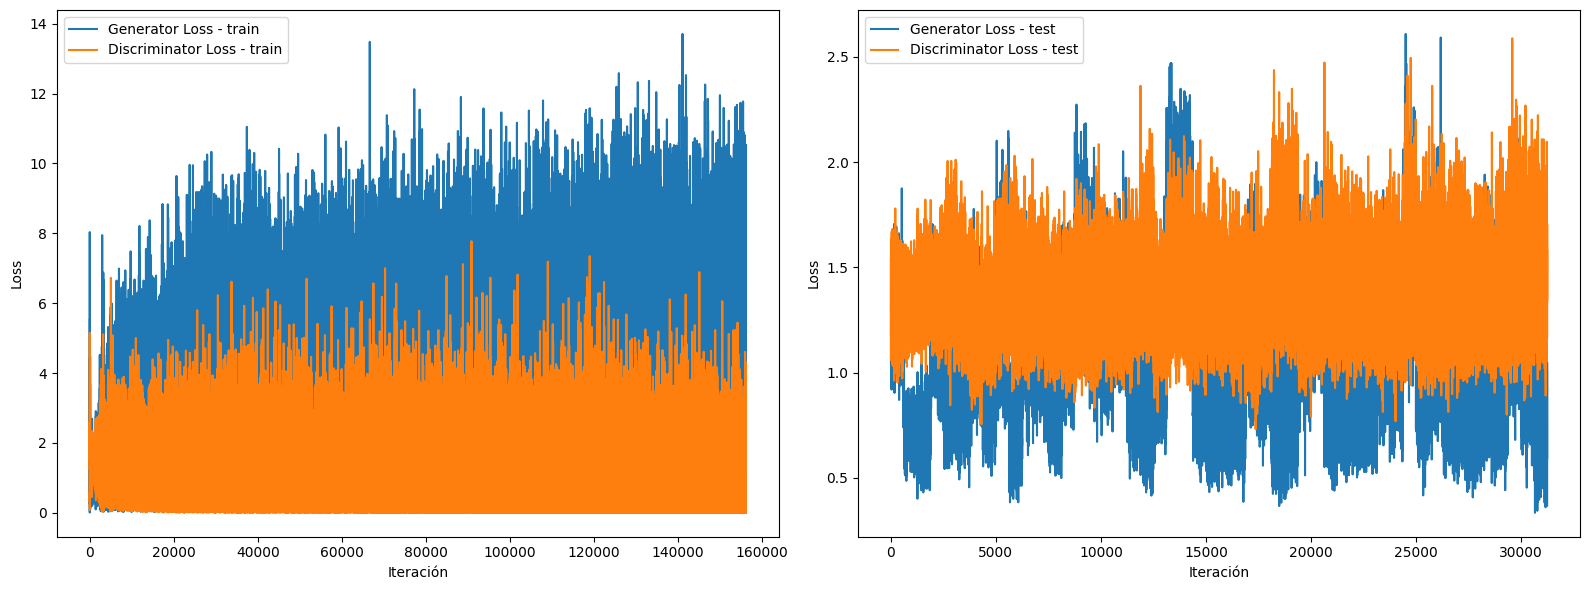

In [19]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m5_cifar100.npz")

iteration_train = np.arange(1, len(X_train)/batch_size*epoch_count+1)
iteration_test = np.arange(1, len(X_test)/batch_size*epoch_count+1)
d_loss_itern_train = data['d_loss_itern_train']
g_loss_itern_train = data['g_loss_itern_train']
d_loss_itern_test = data['d_loss_itern_test']
g_loss_itern_test = data['g_loss_itern_test']

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(iteration_train, g_loss_itern_train, label='Generator Loss - train')
axs[0].plot(iteration_train, d_loss_itern_train, label='Discriminator Loss - train')
axs[0].set_xlabel('Iteración')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(iteration_test, g_loss_itern_test, label='Generator Loss - test')
axs[1].plot(iteration_test, d_loss_itern_test, label='Discriminator Loss - test')
axs[1].set_xlabel('Iteración')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

# Graficas de la pérdida para el generador y el discriminador en función de las épocas

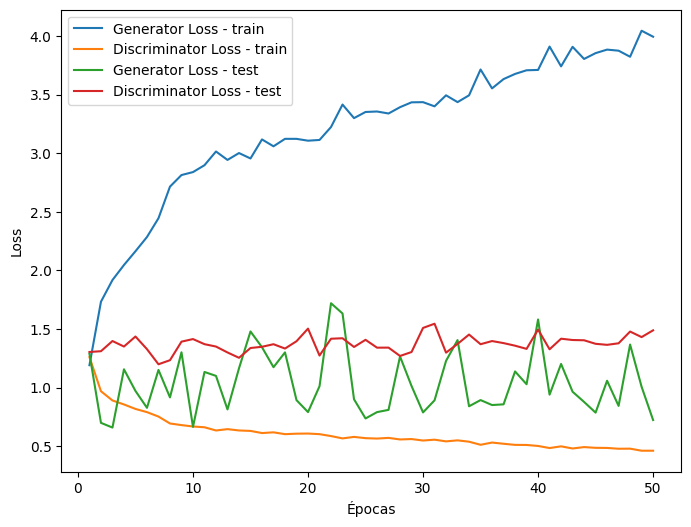

In [20]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m5_cifar100.npz")

epochs = data['epochs']
d_loss_train = data['d_loss_train']
g_loss_train = data['g_loss_train']
d_loss_test = data['d_loss_test']
g_loss_test = data['g_loss_test']

plt.figure(figsize=(8,6))
plt.plot(epochs, g_loss_train, label='Generator Loss - train')
plt.plot(epochs, d_loss_train, label='Discriminator Loss - train')
plt.plot(epochs, g_loss_test, label='Generator Loss - test')
plt.plot(epochs, d_loss_test, label='Discriminator Loss - test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficas de las métricas para el discriminador en función del número de épocas

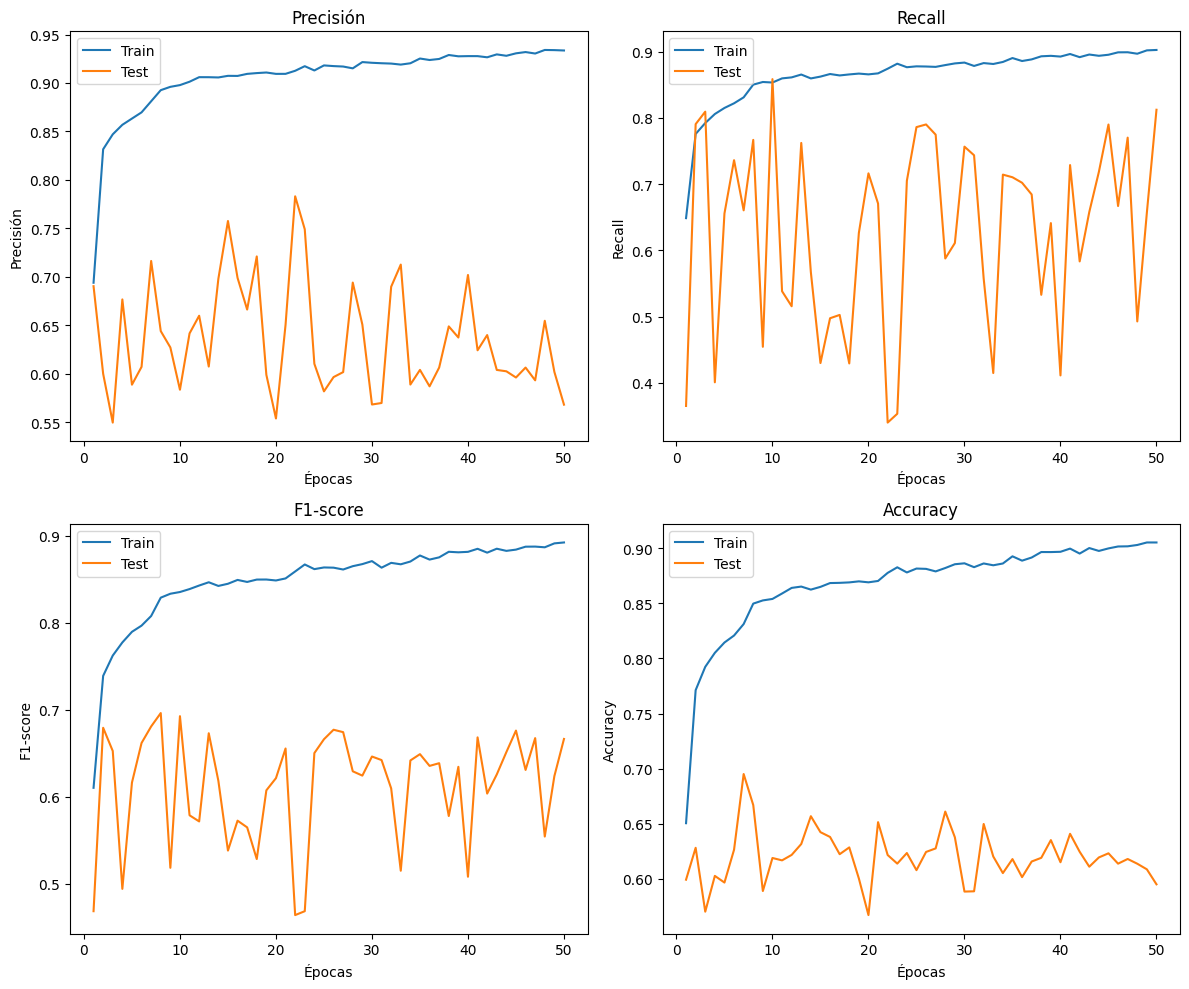

In [21]:
data = np.load("/content/drive/MyDrive/Lembo/metricas_m5_cifar100.npz")
epochs = data['epochs']
precision_train = data['precision_train']
recall_train = data['recall_train']
f1_train = data['f1_train']
accuracy_train = data['accuracy_train']
precision_test = data['precision_test']
recall_test = data['recall_test']
f1_test = data['f1_test']
accuracy_test = data['accuracy_test']

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
epochs = np.arange(1, epoch_count + 1)
axs[0, 0].plot(epochs, precision_train, label='Train')
axs[0, 0].plot(epochs, precision_test, label='Test')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Precisión')
axs[0, 0].legend()
axs[0, 0].set_title('Precisión')
axs[0, 1].plot(epochs, recall_train, label='Train')
axs[0, 1].plot(epochs, recall_test, label='Test')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Recall')
axs[0, 1].legend()
axs[0, 1].set_title('Recall')
axs[1, 0].plot(epochs, f1_train, label='Train')
axs[1, 0].plot(epochs, f1_test, label='Test')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('F1-score')
axs[1, 0].legend()
axs[1, 0].set_title('F1-score')
axs[1, 1].plot(epochs, accuracy_train, label='Train')
axs[1, 1].plot(epochs, accuracy_test, label='Test')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].set_title('Accuracy')
plt.tight_layout()
plt.show()

# Generación de una imagen del cifar 100 pedida por el usuario

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image

noise_dim = 100 # Dimension del ruido

tags = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
def get_index(word, tags_list):
    try:
        return tags_list.index(word)
    except ValueError:
        return -1  # Devuelve -1 si la palabra no se encuentra en la lista

# Cargar el modelo generador
g_model = load_model('gmodel_m5_cifar100.h5')

imagen_a_generar = 'bus'
index = get_index(imagen_a_generar, tags)

#label = tf.expand_dims(numero_a_generar, axis=-1) #expando la dimension de y_train para que quede analogo al ejemplo del cifar10
label = tf.ones(1)*index

# Generar ruido aleatorio
noise = tf.random.normal(shape=(1, noise_dim))

# Generar imagen falsa
generated_image = g_model([noise, label]) #  Genero imagenes falsas
#generated_image = g_model.predict([noise, label])
print("Tamaño imagen generada: ", generated_image.shape)

plt.figure(figsize=(2,2))
img = image.array_to_img(generated_image[0], scale=True)
plt.imshow(img)
plt.axis('off')
#plt.title(f"{tags[index]}")
plt.show()

OSError: No file or directory found at gmodel_m5_cifar100.h5